# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Behavioral learning

The goals / steps of this project are the following:
* Use the simulator to collect data of good driving behavior
* Build, a convolution neural network in Keras that predicts steering angles from images
* Train and validate the model with a training and validation set
* Test that the model successfully drives around track one without leaving the road
* Summarize the results with a written report

## Credits
List of websites / repositories that helped reach this solution:
* None

## Imports

In [1]:
# Environment
# Python 3.7, TensorFlow 1.15

from os import getcwd, listdir # Listing files
from os.path import isfile, dirname, join # Checking if file is file or directory / building file path
import cv2 # Reading images and images operations
import csv # Images vehicle data
import random # Random image display
import matplotlib.pyplot as plt # All plots


import math # For generic math operations
import numpy as np

import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


---
## Step 0: Load the data

In [2]:
from IPython.display import clear_output


driving_log_path = 'data/driving_log.csv'

def load_driving_data(driving_log_path, header=True, delimiter=',', sa_lr_corr=0.2, verbose=True):
    # Images path is expected to be relative to the driving data directory
    lines=0
    imgs=None
    snsrs=None
    with open(driving_log_path, 'r') as driving_log_file:
        # Retrieve log directory
        driving_log_dir = dirname(driving_log_path)        
        reader = csv.reader(driving_log_file, delimiter=delimiter)
        for line in reader:
            if(reader.line_num % 100 == 0):
                clear_output(wait=True)
                print("Reading line {}".format(reader.line_num), flush=True)
            if header:
                header = False
                continue
            
            lines = lines + 1
            # Center, Left, Right images
            img_cntr_path = join(driving_log_dir, line[0].strip())
            img_left_path = join(driving_log_dir, line[1].strip())
            img_right_path = join(driving_log_dir, line[2].strip())
                        
            #img_cntr = np.asarray(cv2.imread(img_cntr_path))
            #img_left = np.asarray(cv2.imread(img_left_path))
            #img_right = np.asarray(cv2.imread(img_right_path))
            
            # Sensor data: Sensors (snsrs), Steering angle (sa), throttle (thr), brake (brk), speed (spd)
            sa_cntr = float(line[3])
            #thr = float(line[4])
            #brk = float(line[5])
            #spd = float(line[6])
            # Adjusted steering angle for left and right images
            sa_left = sa_cntr + sa_lr_corr # Steer to the right
            sa_right = sa_cntr - sa_lr_corr # Steer to the left

            # Building images and sensors arrays
            #imgs_new = np.concatenate(([img_cntr], [img_left], [img_right]))
            imgs_new = np.concatenate(([img_cntr_path], [img_left_path], [img_right_path]))
            
            #snsrs_cntr = np.concatenate(([sa_cntr], [thr], [brk], [spd]))
            #snsrs_left = np.concatenate(([sa_left], [thr], [brk], [spd]))
            #snsrs_right = np.concatenate(([sa_right], [thr], [brk], [spd]))            
            #snsrs_new = np.concatenate(([snsrs_cntr], [snsrs_left], [snsrs_right]))
            snsrs_new = np.concatenate(([sa_cntr], [sa_left], [sa_right]))
            
            #Image and sensors dataset
            if imgs is None:
                imgs = imgs_new
                snsrs = snsrs_new
            else:
                imgs = np.concatenate((imgs, imgs_new))
                snsrs = np.concatenate((snsrs, snsrs_new))
            
    clear_output(wait=True)
    return imgs, snsrs, lines

In [3]:
imgs, snsrs, lines = load_driving_data(driving_log_path)

Reading line 8000


---

## Step 1: Dataset exploration & summary

The data is an array composed of 7 values pairs:
center,left,right,steering,throttle,brake,speed
- `'center'` is the relative path to the image from the center camera of the vehicle.
- `'left'` is the relative path to the image from the center camera of the vehicle.
- `'right'` is the relative path to the image from the center camera of the vehicle.
- `'steering'` float between -1 and 1 representing the steering angle.
- `'throttle'` float between 0 and 1 representing the throttle command.
- `'brake'` float between 0 and 1 representing the brake command.
- `'speed'` float between representing the vehicle speed.


### 1.1 Basic Summary of the dataset

In [4]:
print("Lines: {}".format(lines))
print("Images: {}".format(len(imgs)))
image_shape = np.asarray(cv2.imread(imgs[0])).shape
print("- Shape: {}".format(image_shape))

print("Sensors: {}".format(len(snsrs)))

Lines: 8036
Images: 24108
- Shape: (160, 320, 3)
Sensors: 24108


### 1.2 Visual summary of the dataset

In [5]:
# Visualizations will be shown in the notebook.
#%matplotlib inline

#### Visualize random images and vehicle data

In [25]:
def resize_img(img, w=320, h=160, interpolation=cv2.INTER_AREA):
    dst = cv2.resize(img, (w, h),  interpolation=interpolation)
    return dst

def overlay_img(img, sa, sa_pred, w=320, h=160, interpolation=cv2.INTER_AREA):
    # Assuming image is RGB
    dst = cv2.resize(img, (w, h), interpolation=interpolation)
    
    # Overlay sensor information
    cv2.putText(dst, "ANGLE {}".format(sa),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                org=(4, 16), fontScale=.5,
                color=(128, 255, 128),
                thickness=1)
    
    # Overlay predicted steering angle
    if sa_pred is not None:
        cv2.putText(dst, "PRED. ANGLE {}".format(sa_pred),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            org=(4, 32), fontScale=.5,
            color=(128, 255, 128),
            thickness=1)
    return dst



def plot_imgs(imgs, snsrs=None, snsrs_pred=None, header=None, gray=False, imgs_limit=12):
    # Prevent long processing time if not explicitely asked by setting display limit
    if(imgs_limit > len(imgs)):
        imgs_limit = len(imgs)
    
    # Determine size of subplots matrix
    figsize=(20,3.5)
    cols=3
    rows = math.ceil(imgs_limit/cols)    
    fig, axs = plt.subplots(rows, cols, figsize=(figsize[0], figsize[1]*rows))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    
    # Transform matrix of subplots to a flattened one-dimensional array
    axs = axs.ravel()
    
    # Display each image in subplots
    for i in range(imgs_limit):
        # Remove axis as we are displaying images
        axs[i].axis('off')

        # Collect image sensors information if vailable
        snsr=""
        if snsrs is not None:
            snsr=snsrs[i]

        snsr_pred=""
        if snsrs_pred is not None:
            snsr_pred=snsrs_pred[i]

        # Build overlayed image
        img = overlay_img(imgs[i], snsr, snsr_pred)

        # Display image and title
        if(gray):                
            axs[i].imshow(img, cmap='gray')
        else:
            axs[i].imshow(img)
        title = ""
        if header is not None:
            title = header[i]
        axs[i].set_title(title, fontsize=12)

    # Hide unused subplots
    while i < len(axs):
        axs[i].axis('off')
        i = i + 1
    plt.show()

# Plot random images
def plot_imgs_rand(imgs, snsrs, gray=False, imgs_limit=50):
    # List of randomly picked images and their sensors value
    imgs_rand = []
    snsrs_rand = [] 
        
    # For each unique label in available images
    for i in range(imgs_limit):
        # Pick a random image in the dataset
        img_rand_id = np.random.choice(len(imgs))
        img_rand = cv2.cvtColor(cv2.imread(imgs[img_rand_id]), cv2.COLOR_BGR2RGB)
        imgs_rand.append(img_rand)
        snsrs_rand.append(snsrs[img_rand_id])

    plot_imgs(imgs_rand,snsrs_rand, gray=gray, imgs_limit=imgs_limit)

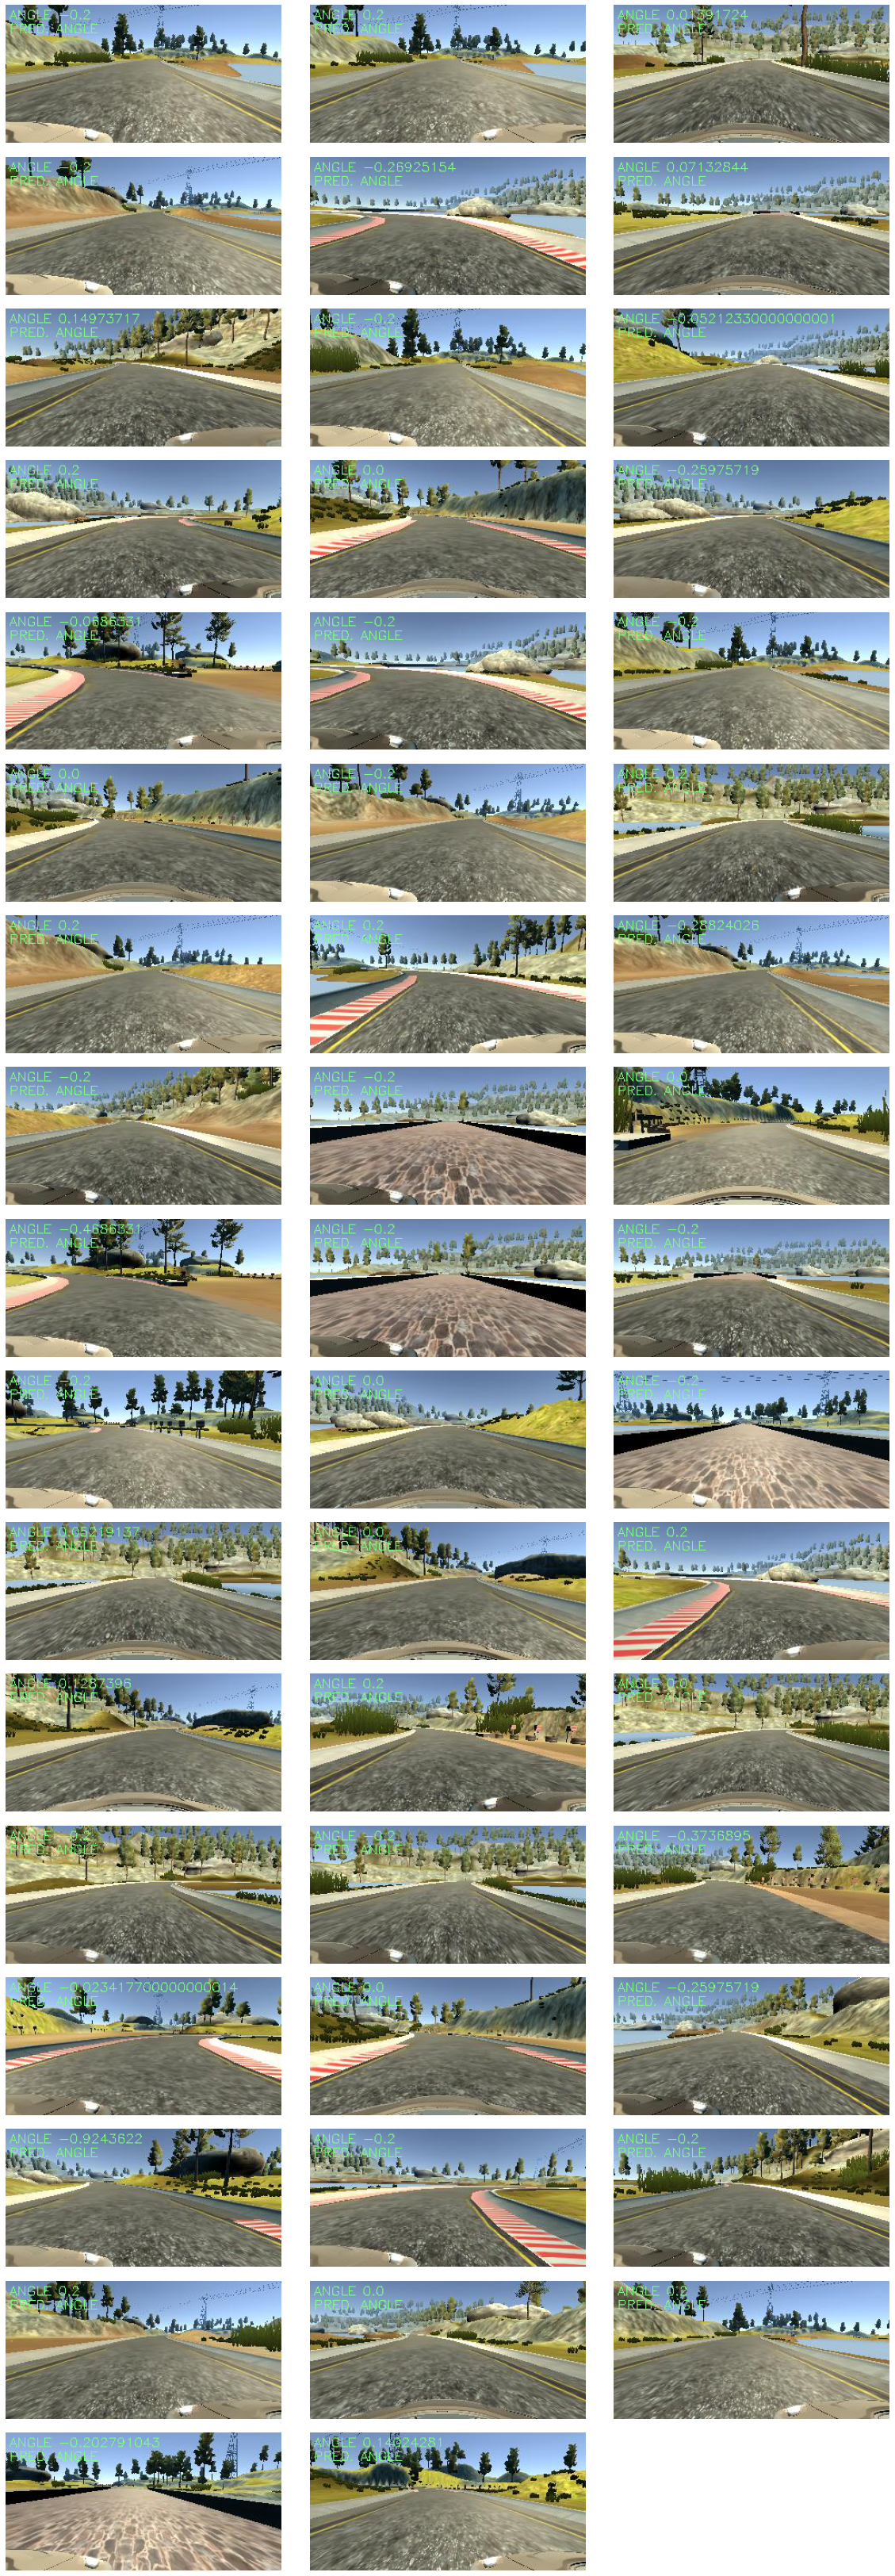

In [26]:
plot_imgs_rand(imgs, snsrs)

In [ ]:
# Visualizations will be shown in the notebook.

# Pick the first image from the training set for each sign and display its name
plot_lbl_imgs(X_train,y_train, gray=False)

#### Analyze arrangement of training data

In [27]:
# Bar chart with repartition of data depending on steering angle

----

## Step 2: Pre-process dataset

### Pre-process the dataset

#### Crop  images
Crop images to remove irrelevant information from the FOV

#### Resize images
Resize images to match the model input layer

In [28]:
def resize_img(img, w=320, h=160, interpolation=cv2.INTER_AREA):
    dst = cv2.resize(img, (w, h),  interpolation=interpolation)
    return dst

#### Augment dataset
Augmentation methods used:
* Random horizontal / vertical translate
 * NOT USED: Not relevant as it would modify road position on image
* Random rotate (almost same result as perspective warp would do)
 * NOT USED: Not relevant as it would modify road position on image
* Random scale (zoom/unzoom)
 * NOT USED: Not relevant, would only be helful if road changed in width
* Random perspective warp (as used in lane finding)
 * NOT USED: Not relevant, would modify road curvature (affects steering angle) and scale (see scale comment)
* Random colors change
 * More relevant as we want to ignore road surface and road side type

In [30]:
def rand_hsv_channel(img, channel, shift=64):
    rows,cols,_ = img.shape
        
    # Transform image to HSV to easily manipulate brightness/saturation
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Allow channel shift to be between -shift to +shift V
    d_shift = np.random.randint(-shift,shift)
    hsv[:,:,channel] = cv2.add(hsv[:,:,channel],d_shift)    
    dst = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return dst

def rand_hsv_h(img, shift=64):
    return rand_hsv_channel(img, 0, shift=64)
def rand_hsv_s(img, shift=64):
    return rand_hsv_channel(img, 1, shift=64)
def rand_hsv_v(img, shift=64):
    return rand_hsv_channel(img, 2, shift=64)

In [ ]:
def rand_transform(img):
    # Translate, Change perspective (can result in zoom in or out or even rotation), Brightness adjust
    return rand_hsv_h(rand_hsv_s(rand_hsv_v(img)))

def augment_lbl(imgs, snsrs, min_count=750):
    range_step=5
    
    # Assuming RGB images for shape
    rand_imgs = np.empty_like(imgs, shape=(0, imgs.shape[1], imgs.shape[2], imgs.shape[3]))    
    rand_snsrs = np.empty_like(lbls, shape=(0))
    
    # For steering angle range
    for sa_range in range(-100, 100, range_step):
        # Augment any data up to min_count if necessary
        min_range=sa_range/100
        max_range=(sa_range+range_step)/100
        # FIXME: Include 100 in the range
        snsrs_list = np.where(snsrs >= min_range and snsrs < max_range)[0]
        
        snsrs_count = len(snsrs_list)
        snsrs_augment = min_count - snsrs_count
        if snsrs_augment > 0:
            print("Range [{0:4};{1:4}[ requires {2} augmentations".format(min_range, max_range, snsrs_augment))
            # Add as many augmented images as necessary
            for i in range(snsrs_augment):
                # Pick images one after the other, and loop if necessary
                # DO STUFF...
        else:
            pass
            #print("Range [{0:4};{1:4}[ doe snot require augmentation".format(min_range, max_range))

    return rand_imgs, rand_snsrs

#### Grayscale images

In [ ]:
# https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python/45338831
def rgb_2_gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

#### Shuffle dataset
Shuffle (after grayscale to manipulate less data) the set so that no drift occurs after many successions of the same sign during the learning

In [ ]:
# Shuffle based on steering angle

#### Normalize dataset to [ -1, 1 ]
Normalize data to obtain a mean close to 0 and try to speed up learning and reach faster convergence

In [ ]:
def normalize_gray(imgs):
    # Subtract half the max (256) value to center around 0 then divide by the same value to obtain a [-1;1] range
    return (imgs - 128)/128     

----

## Step 3: Create model architecture


The model architecture is based on the [NVidia architecture](https://classroom.udacity.com/nanodegrees/nd013/parts/168c60f1-cc92-450a-a91b-e427c326e6a7/modules/95d62426-4da9-49a6-9195-603e0f81d3f1/lessons/3fc8dd70-23b3-4f49-86eb-a8707f71f8dd/concepts/7f68e171-cf87-40d2-adeb-61ae99fe56f5)

### Step 4: Train, validate and test model

#### Setup TensorFlow

#### Trials & Results
##### 1. NVidia architecture
##### 2. Enhancing dataset
##### 3. Augmenting dataset